# Analysis of coverage differences in conserved and neutral regions

Previously we found out that patterns of ancient DNA damage differ significantly between different regions of the genome. We hypothesise that ancient fragments map more poorly in highly diverged regions than in conserved regions, due to an increased number of ymismatches due to damage on top of normal divergence.

We are going to use genome annotation data to get regions of the genome that are protein coding (proxy for conserved) and neutral (pseudogenes etc.).

GTF/GFF format definitions:

* http://www.ensembl.org/info/website/upload/gff.html
* http://gmod.org/wiki/GFF2

[ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/README]()

Definitions of different features are here: http://www.sequenceontology.org/index.html

For example for [CDS](http://www.sequenceontology.org/browser/current_svn/term/SO:0000316)

In [1]:
import os.path
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pybedtools import BedTool

In [2]:
plt.style.use('ggplot')

In [3]:
%matplotlib inline

In [4]:
tmp_dir = '../tmp'

### Function definitions

In [18]:
CODING_FEATURES    = ['protein_coding']
NONCODING_FEATURES = [                   
    'pseudogene',
    'processed_pseudogene',
    'transcribed_processed_pseudogene',
    'transcribed_unprocessed_pseudogene',
    'unprocessed_pseudogene'
]


def filter_chromosome(regions, chrom):
    path, filename = os.path.split(regions.fn)
    
    return regions.filter(lambda f: f.chrom == chrom) \
                  .sort()                             \
                  .saveas(os.path.join(path, 'chr' + chrom + '_' + filename))
                

def filter_features(regions, feature_type):
    '''Filter given GTF annotations into a specified feature type subset.'''
    path, filename = os.path.split(regions.fn)
    
    if feature_type == 'coding':
        features = CODING_FEATURES 
    elif feature_type == 'noncoding':
        features = NONCODING_FEATURES
    else:
        raise ValueError('feature_type must be either "coding" or "noncoding"')
    
    return regions.filter(lambda f: f[1] in features) \
                  .sort()                             \
                  .merge()                            \
                  .saveas(os.path.join(path, feature_type + '_' + filename))

                    
def coverage_depth(bam_file, regions):
    '''Return a data frame with'''
    bam = BedTool(bam_file)
    return regions.coverage(bam, d=True).to_dataframe()['score']


def coverage_filter(cvg, q=0.975):
    '''Remove positions with coverage higher than q.'''
    return cvg[cvg < cvg.quantile(q)]


def coverage_in_bam(bam_file, coding_regions, noncoding_regions, *,
                    filter_quantile=0.975, subsample=True):
    '''Calculate coverage in a given BAM file in coding and non-coding
    regions of the genome.
    '''
    coding_cvg = coverage_depth(bam_file, coding_regions)
    noncoding_cvg = coverage_depth(bam_file, noncoding_regions)
    
    if filter_quantile:
        coding_cvg = coverage_filter(coding_cvg, filter_quantile)
        noncoding_cvg = coverage_filter(noncoding_cvg, filter_quantile)

    if subsample:
        sample_size = len(coding_cvg) if len(coding_cvg) < len(noncoding_cvg) else len(noncoding_cvg)
        coding_cvg = coding_cvg.sample(sample_size)
        noncoding_cvg = noncoding_cvg.sample(sample_size)

    categories = ['coding', 'non-coding']
    coding_df  = pd.DataFrame({'region': pd.Categorical([categories[0]] * len(coding_cvg), categories), 'cvg': coding_cvg})
    noncoding_df = pd.DataFrame({'region': pd.Categorical([categories[1]] * len(noncoding_cvg), categories), 'cvg': noncoding_cvg})
    
    return pd.concat([coding_df, noncoding_df])


def summarize_coverages(coverages, bam_file):
    '''Plot distributions of coverage in coding vs noncoding regions.'''
    
    print('Summary of coverages in coding/non-coding regions in ', bam_file)
    print('=============================================')
    
    groups = coverages.query('cvg > 0').groupby('region')
    
    coding_cvg = groups.get_group('coding')['cvg']
    noncoding_cvg = groups.get_group('non-coding')['cvg']
    
    print(groups.describe(percentiles=[0.5]))
    
    print()
    
    print('Proportion of sites with zero coverage:')
    print('\tin coding regions:\t', (coding_cvg == 0).mean())
    print('\tin non-coding regions:\t', (noncoding_cvg == 0).mean())
    
    print()
    
    s1, p1 = stats.mannwhitneyu(coding_cvg, noncoding_cvg, alternative='greater')
    s2, p2 = stats.mannwhitneyu(coding_cvg[coding_cvg > 0], noncoding_cvg[noncoding_cvg > 0])
                                
    print('Difference in coverage between two classes regions? (Mann-Whitney U test)')
    print('\tincluding sites with no coverage: p-value = ', p1)
    print('\tonly sites with coverage: pvalue = ', p2)
    
    plt.figure(figsize=(12, 6))
    plt.xlim(0, coverages.cvg.max())
    plt.xlabel('coverage')
    plt.ylabel('density')
    plt.title(os.path.basename(bam_file))

    sns.distplot(groups.get_group('coding')['cvg'], bw=1)
    sns.distplot(groups.get_group('non-coding')['cvg'], bw=1)

    plt.legend(['coding', 'non-coding'])

### Download genome annotations

In [19]:
gtf_file = os.path.join(tmp_dir, 'Homo_sapiens.GRCh37.75.gtf.gz')

In [7]:
!curl ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz > $gtf_file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37.5M  100 37.5M    0     0  10.3M      0  0:00:03  0:00:03 --:--:-- 10.3M


### Load coordinates of protein coding regions and pseudogenes on the Y chromosome

In [20]:
map_filter = BedTool('/mnt/454/HCNDCAM/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz')

In [21]:
genome_gtf_file = os.path.join(tmp_dir, 'map99_Homo_sapiens.GRCh37.75.gtf.gz')

if os.path.exists(genome_gtf_file):
    genome_gtf = BedTool(genome_gtf_file)
else:
    genome_gtf = BedTool(gtf_file)         \
                    .intersect(map_filter) \
                    .saveas(genome_gtf_file)

In [22]:
y_gtf = filter_chromosome(genome_gtf, 'Y')

In [23]:
y_coding = filter_features(y_gtf, 'coding')
y_noncoding = filter_features(y_gtf, 'noncoding')

### What is the size of coding and pseudogene regions?

In [24]:
print('Coding regions: \t{} bp'.format(y_coding.total_coverage()))
print('Non-coding regions:\t{} bp'.format(y_noncoding.total_coverage()))

Coding regions: 	680686 bp
Non-coding regions:	459548 bp


### Calculate depth of coverage for each site in each region

## Ust-Ishim

In [12]:
ui_coverages = coverage_in_bam('/mnt/expressions/mp/y-selection/bam/y_ustishim.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  /mnt/expressions/mp/y-selection/bam/y_ustishim.bam
                            cvg
region                         
coding     count  439250.000000
           mean       21.523376
           std         5.892967
           min         1.000000
           50%        22.000000
           max        34.000000
non-coding count  424178.000000
           mean       20.139482
           std         6.244435
           min         1.000000
           50%        20.000000
           max        33.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.0
	only sites with coverage: pvalue =  0.0


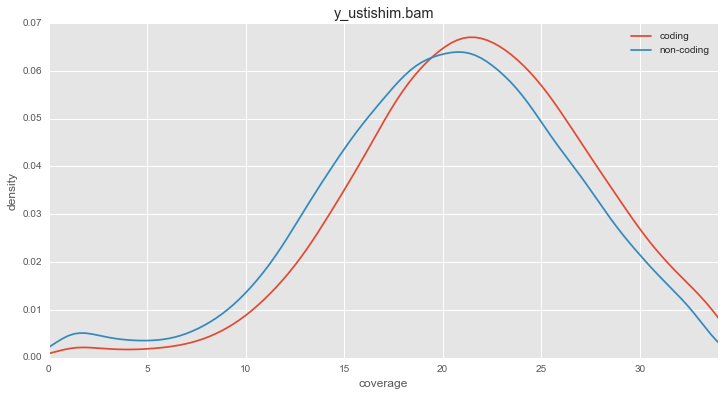

In [23]:
summarize_coverages(ui_coverages, '/mnt/expressions/mp/y-selection/bam/y_ustishim.bam')

## A00

In [14]:
a00_coverages = coverage_in_bam('../a00_1.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../a00_1.bam
                            cvg
region                         
coding     count  434649.000000
           mean        8.610904
           std         3.325597
           min         1.000000
           50%         8.000000
           max        16.000000
non-coding count  420130.000000
           mean        8.572866
           std         3.412075
           min         1.000000
           50%         8.000000
           max        16.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  8.90012191545e-09
	only sites with coverage: pvalue =  1.78002438309e-08


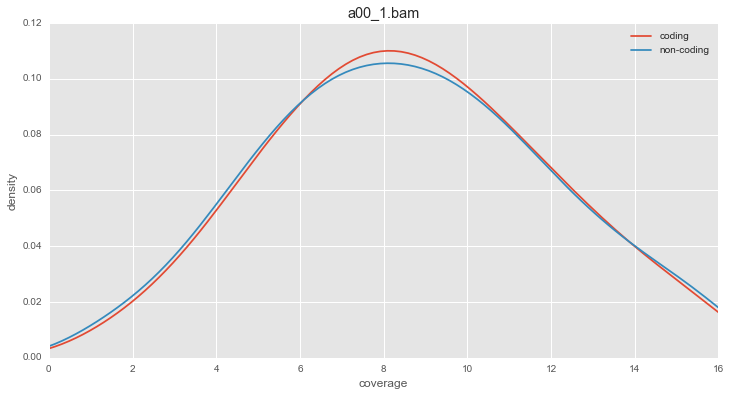

In [24]:
summarize_coverages(a00_coverages, '../a00_1.bam')

## Anonymous donor &mdash; normal

In [17]:
anon_default = coverage_in_bam('../donor_default.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../donor_default.bam
                            cvg
region                         
coding     count  433347.000000
           mean       10.681456
           std         3.139949
           min         1.000000
           50%        11.000000
           max        17.000000
non-coding count  416363.000000
           mean       10.665933
           std         3.262076
           min         1.000000
           50%        11.000000
           max        17.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.997404382567
	only sites with coverage: pvalue =  0.00519123500811


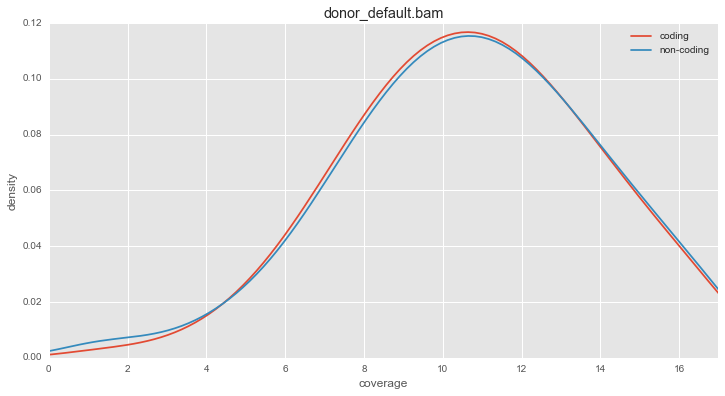

In [25]:
summarize_coverages(anon_default, '../donor_default.bam')

## Anonymous donor &mdash; ancient

In [19]:
anon_default = coverage_in_bam('../donor_ancient.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../donor_ancient.bam
                            cvg
region                         
coding     count  433347.000000
           mean       10.681456
           std         3.139949
           min         1.000000
           50%        11.000000
           max        17.000000
non-coding count  416363.000000
           mean       10.665933
           std         3.262076
           min         1.000000
           50%        11.000000
           max        17.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.997404382567
	only sites with coverage: pvalue =  0.00519123500811


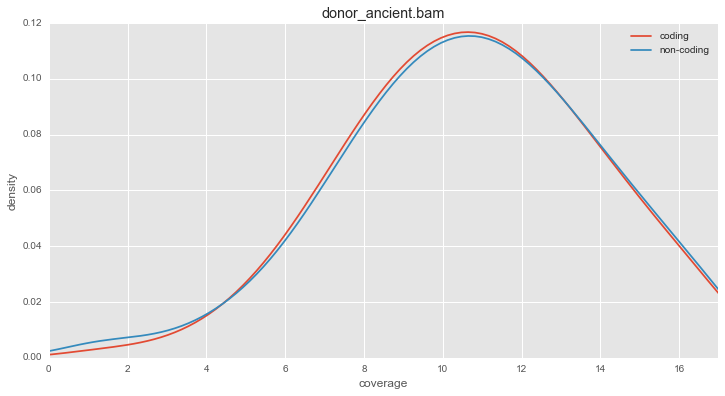

In [26]:
summarize_coverages(anon_default, '../donor_ancient.bam')

In [29]:
%%R -i anon_default
wilcox.test(cvg ~ region, data=anon_default) 

# Coverage in exome regions vs Basti's regions

In [118]:
lippold_bed = BedTool('../input/lippold_regions.bed')
exome_bed = BedTool('../input/exome_regions.bed')

In [119]:
coding_bed = lippold_bed.intersect(exome_bed)
noncoding_bed = lippold_bed.subtract(exome_bed)

## El Sidron

In [120]:
sidron_coverages = coverage_in_bam('../bam/lippold_sidron.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../bam/lippold_sidron.bam
                           cvg
region                        
coding     count  18446.000000
           mean      10.181069
           std        4.939653
           min        0.000000
           50%       10.000000
           max       22.000000
non-coding count  18446.000000
           mean       7.963190
           std        4.829991
           min        0.000000
           50%        8.000000
           max       20.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00840290577903
	in non-coding regions:	 0.0450504174347

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.0
	only sites with coverage: pvalue =  5.10089422855e-294


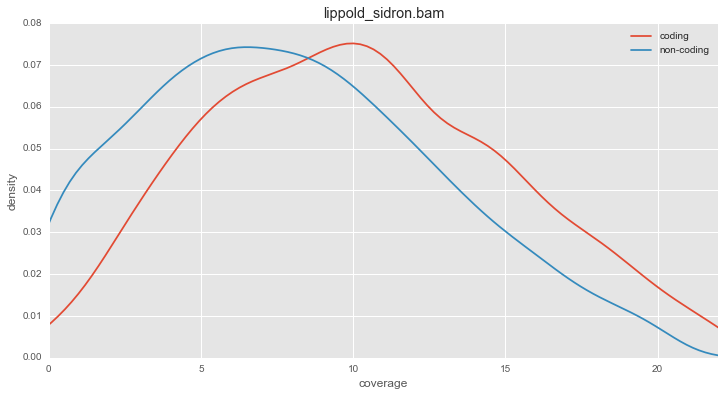

In [121]:
summarize_coverages(sidron_coverages, '../bam/lippold_sidron.bam')

## A00

In [122]:
a00_coverages = coverage_in_bam('../a00_1.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../a00_1.bam
                           cvg
region                        
coding     count  18300.000000
           mean       9.266776
           std        3.515213
           min        0.000000
           50%        9.000000
           max       17.000000
non-coding count  18300.000000
           mean       8.827705
           std        3.486429
           min        0.000000
           50%        9.000000
           max       17.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00218579234973
	in non-coding regions:	 0.00628415300546

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  4.41785961428e-31
	only sites with coverage: pvalue =  8.76751311764e-28


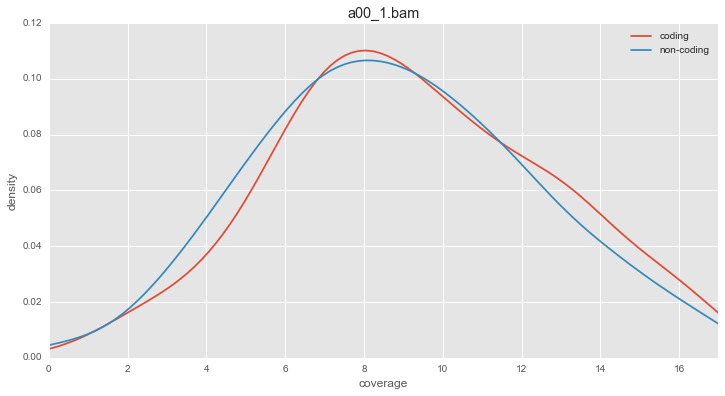

In [123]:
summarize_coverages(a00_coverages, '../a00_1.bam')

## Ust-Ishim

In [124]:
ui_coverages = coverage_in_bam('../../y-selection/bam/y_ustishim.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_ustishim.bam
                           cvg
region                        
coding     count  18429.000000
           mean      19.908134
           std        5.466433
           min        0.000000
           50%       20.000000
           max       32.000000
non-coding count  18429.000000
           mean      20.442238
           std        5.772173
           min        0.000000
           50%       21.000000
           max       33.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.000596885343752
	in non-coding regions:	 0.00450377123013

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  1.0
	only sites with coverage: pvalue =  5.89902683287e-25


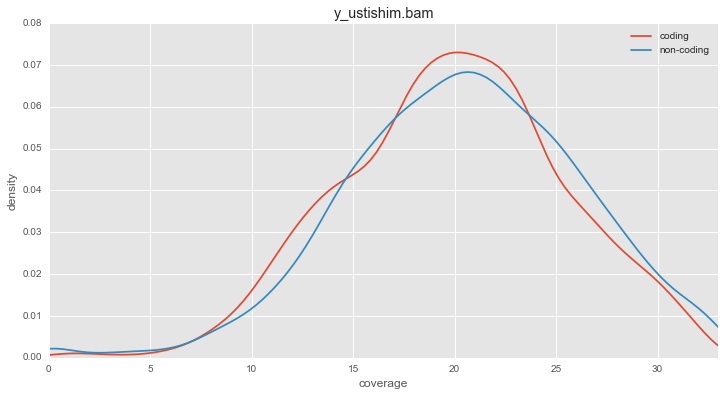

In [125]:
summarize_coverages(ui_coverages, '../../y-selection/bam/y_ustishim.bam')

## Mota

In [126]:
mota_coverages = coverage_in_bam('../../y-selection/bam/y_mota.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_mota.bam
                           cvg
region                        
coding     count  18262.000000
           mean       6.472511
           std        2.663540
           min        0.000000
           50%        6.000000
           max       12.000000
non-coding count  18262.000000
           mean       6.309440
           std        2.610761
           min        0.000000
           50%        6.000000
           max       12.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00662578030884
	in non-coding regions:	 0.0112254955646

Difference in coverage between two classes regions? (Mann-Whitney U test)
	including sites with no coverage: p-value =  1.27649779998e-08
	only sites with coverage: pvalue =  1.0968131785e-06


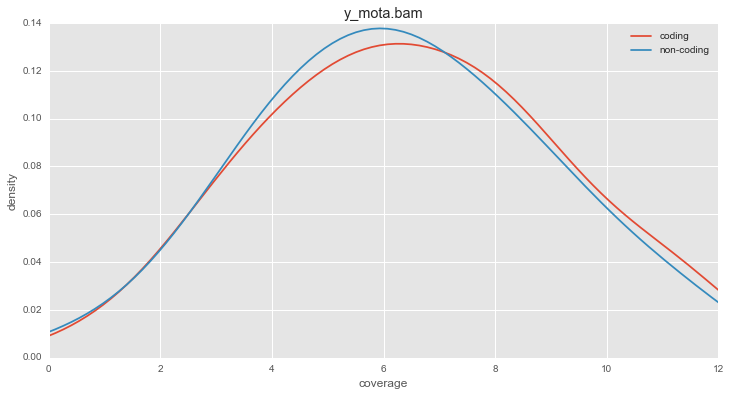

In [127]:
summarize_coverages(mota_coverages, '../../y-selection/bam/y_mota.bam')